Based on [Sentiment Analysis on Reddit News tutorial](http://www.learndatasci.com/sentiment-analysis-reddit-headlines-pythons-nltk/)

Categorize news articles as positive, negative or neutral based on overall sentiment of content

In [1]:
import requests
import json
import time
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

/Users/Tenorio/anaconda/lib/python3.5/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


### Collect articles from /politics subreddit
Set the header as follows: `<platform>:<app ID>:<version string> (by /u/<reddit username>)`

Collect news articles in batches of 25 until a total of 125 is reached.

In [2]:
header = {'User-Agent': 'windows:r/politics.single.result:v1.0' +
       '(by /u/anaerobeth)'}
url = 'https://www.reddit.com/r/politics/.json'
request = requests.get(url, headers=header)
data = json.loads(request.text)

In [61]:
# Collect articles (capped at 125 when accessed on 11/09/2017)
posts = data['data']['children']
number_of_posts = 0

while len(posts) <= 125:
    time.sleep(2)
    last = posts[-1]['data']['name']
    url = 'https://www.reddit.com/r/politics.json?after=' + str(last)
    request = requests.get(url, headers=header)
    data = json.loads(request.text)
    posts += data['data']['children']
    if number_of_posts == len(posts):
        break
    else:
        number_of_posts = len(posts)


### Run sentiment analysis

The method `polarity_score` returns a hash with scores for how positive or negative a headline is.

Example: {'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0}

Headlines with compound value between 0.2 and -0.2 are categorized as neutral.

In [12]:
sia = SIA()
positives = []
negatives = []

for post in posts:
    response = sia.polarity_scores(post['data']['title'])
    if response['compound'] > 0.2:
        positives.append(post['data']['title'])
    elif response['compound'] < -0.2:
        negatives.append(post['data']['title'])

with open("positive_news_titles.txt", "w", encoding='utf-8', errors='ignore') as f_pos:
    for post in positives:
        f_pos.write(post + "\n")

with open("negative_news_titles.txt", "w", encoding='utf-8', errors='ignore') as f_neg:
    for post in negatives:
        f_neg.write(post + "\n")
  

### Dataset distribution
Visualize distribution of headlines according to categories

In [59]:
import matplotlib.pyplot as plt
import matplotlib.style as style
%matplotlib inline

style.use('fivethirtyeight')
percent_positives = len(positives)/125 * 100
percent_negatives = len(negatives)/125 * 100
percent_neutrals = 100 - percent_positives - percent_negatives
percentages = [percent_positives, percent_negatives, percent_neutrals]
x = range(len(percentages))

([<matplotlib.axis.XTick at 0x1184dc2e8>,
 <a list of 3 Text xticklabel objects>)

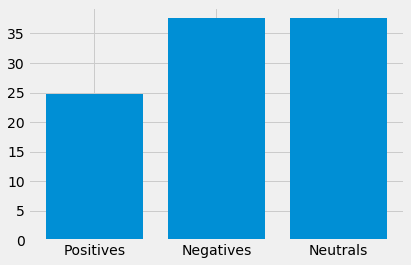

In [60]:
plt.bar(x, percentages)
plt.xticks(x, ['Positives', 'Negatives', 'Neutrals'])

A quarter of all headlines collected on 11/09/2017 are categorized as Positives while the rest are split evenly between Negatives and Neutrals.

### Additional data processing
Set stop words and tokenize sentences then compare the frequencies of words in positive, negative and neutral headlines.

In [73]:
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import math

In [107]:
stop_words = set(stopwords.words('english'))
stop_words.add('u') # Reddit users seem to use this a lot
tokenizer = RegexpTokenizer(r'\w+')

def categorize_words(lines):
    word_list = []
    
    for line in lines:
        words = tokenizer.tokenize(line)
        for word in words:
            w = word.lower()
            if w not in stop_words:
                word_list.append(w)
    
    return word_list

positive_words = categorize_words(positives)
negative_words = categorize_words(negatives)

### Analyze word frequency distribution

In [109]:
positive_words_freq = nltk.FreqDist(positive_words)
negative_words_freq = nltk.FreqDist(negative_words)
print(positive_words_dist.most_common(8))
print(negative_words_dist.most_common(8))

[('trump', 11), ('moore', 5), ('rich', 5), ('gop', 5), ('tax', 4), ('u', 4), ('allegations', 3), ('true', 3)]
[('moore', 12), ('roy', 10), ('trump', 9), ('republicans', 9), ('sexual', 8), ('senate', 6), ('allegations', 4), ('tax', 4)]


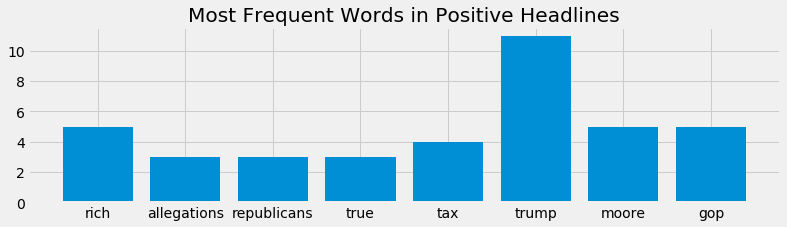

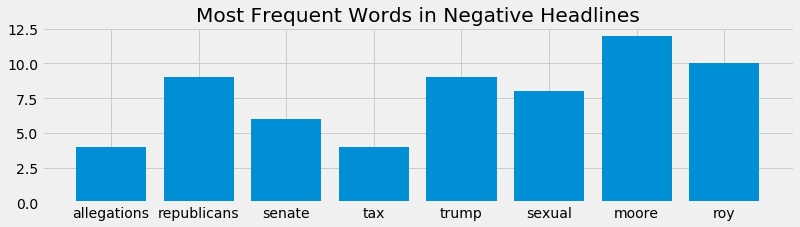

In [114]:
def plot_word_frequencies(words, category):
    freq = nltk.FreqDist(words)
    most_common = dict(freq.most_common(8))
    x = range(len(most_common))
    plt.figure(figsize=(12,3))
    plt.title("Most Frequent Words in {} Headlines".format(category))
    plt.bar(x, most_common.values(), align='center')
    plt.xticks(x, most_common.keys())
    
plot_word_frequencies(positive_words, "Positive")
plot_word_frequencies(negative_words, "Negative")

Positive headlines mostly about 'Trump' who is meeting with Asian leaders while 'tax' is a distant fourth in the same week that the GOP has been releasing the first details of their tax plan.  Negative headlines are dominated by a scandal involving an Alabama candidate for senator (six of eight most frequent words 'moore', 'roy', 'sexual', 'republicans', 'senate' and 'allegations').  Some words such as 'allegations', 'republicans', 'tax', 'trump' and 'moore' appear in both Positives and Negatives list suggesting mixed news coverage and an attempt to downplay the negative coverage of the Moore scandal.